In [66]:
import numpy as np
from scipy.stats import qmc
from expandLHS import ExpandLHS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [74]:

def corner_plot(dataframe, title, dimensions):
    
    things = [',', 'D', 'o', 'v', 's', 'p', 'P', '*', 'X', 'd', '8', '5']
    colors = ['red', 'blue', 'orange', 'green', 'pink', 'olive', 'cyan', 'black', 'brown', 'yellow', 'firebrick', 'tan']
    markers = []
    palette = []


    sns.set(style = "ticks")

    unique_types = dataframe['Type'].nunique()

    for i in range(unique_types):
        markers.append(things[i])
        palette.append(colors[i])

    g = sns.pairplot(dataframe, hue = 'Type', markers = markers, palette = palette, corner = True, diag_kind= None)
    g.fig.suptitle(title, y = 0.85)

    for i, ax_row in enumerate(g.axes):
        for j, ax in enumerate(ax_row):
            if ax:
                if i == j:
                    ax.set_visible(False)
                    continue
                ax.tick_params(direction = 'in', top = True, right = True, length = 4, width = 2, colors = 'black')
                ax.spines['top'].set_visible(True)
                ax.spines['right'].set_visible(True)
    plt.savefig(dimensions, dpi = 300)
    plt.show()

In [76]:
test_param = [-0.98454527, 0.84028646, -1.01608287, 0.03414988, 9.02499104, 0.45168016, 40.0, 500.0, 1.0]
keys = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'M_TURN', 't_STAR', 'L_X','NU_X_THRESH', 'X_RAY_SPEC_INDEX']

input_dict = {k:v for k, v in zip(keys, test_param)}

columns_names = [r'$f_{\star,10}$', r'$\alpha_\star$', r'$f_{ESC,10}$', r'$\alpha_{ESC}$', r'$M_{TURN}$', r'$t_\star$', r'$L_X$', r'$\nu_{X,THRESH}$', r'$X-ray_{spec,index}$']

df = pd.DataFrame([input_dict])
df.columns = columns_names

lower_boundaries = [value - abs(value) * 0.1 for value in df.iloc[0]]
upper_boundaries = [value + abs(value) * 0.1 for value in df.iloc[0]]


Unprogressed sample discrepancy: 0.02691411692625767
Progressed sample 2 discrepancy: 0.020748441261303263
Degree 1.0


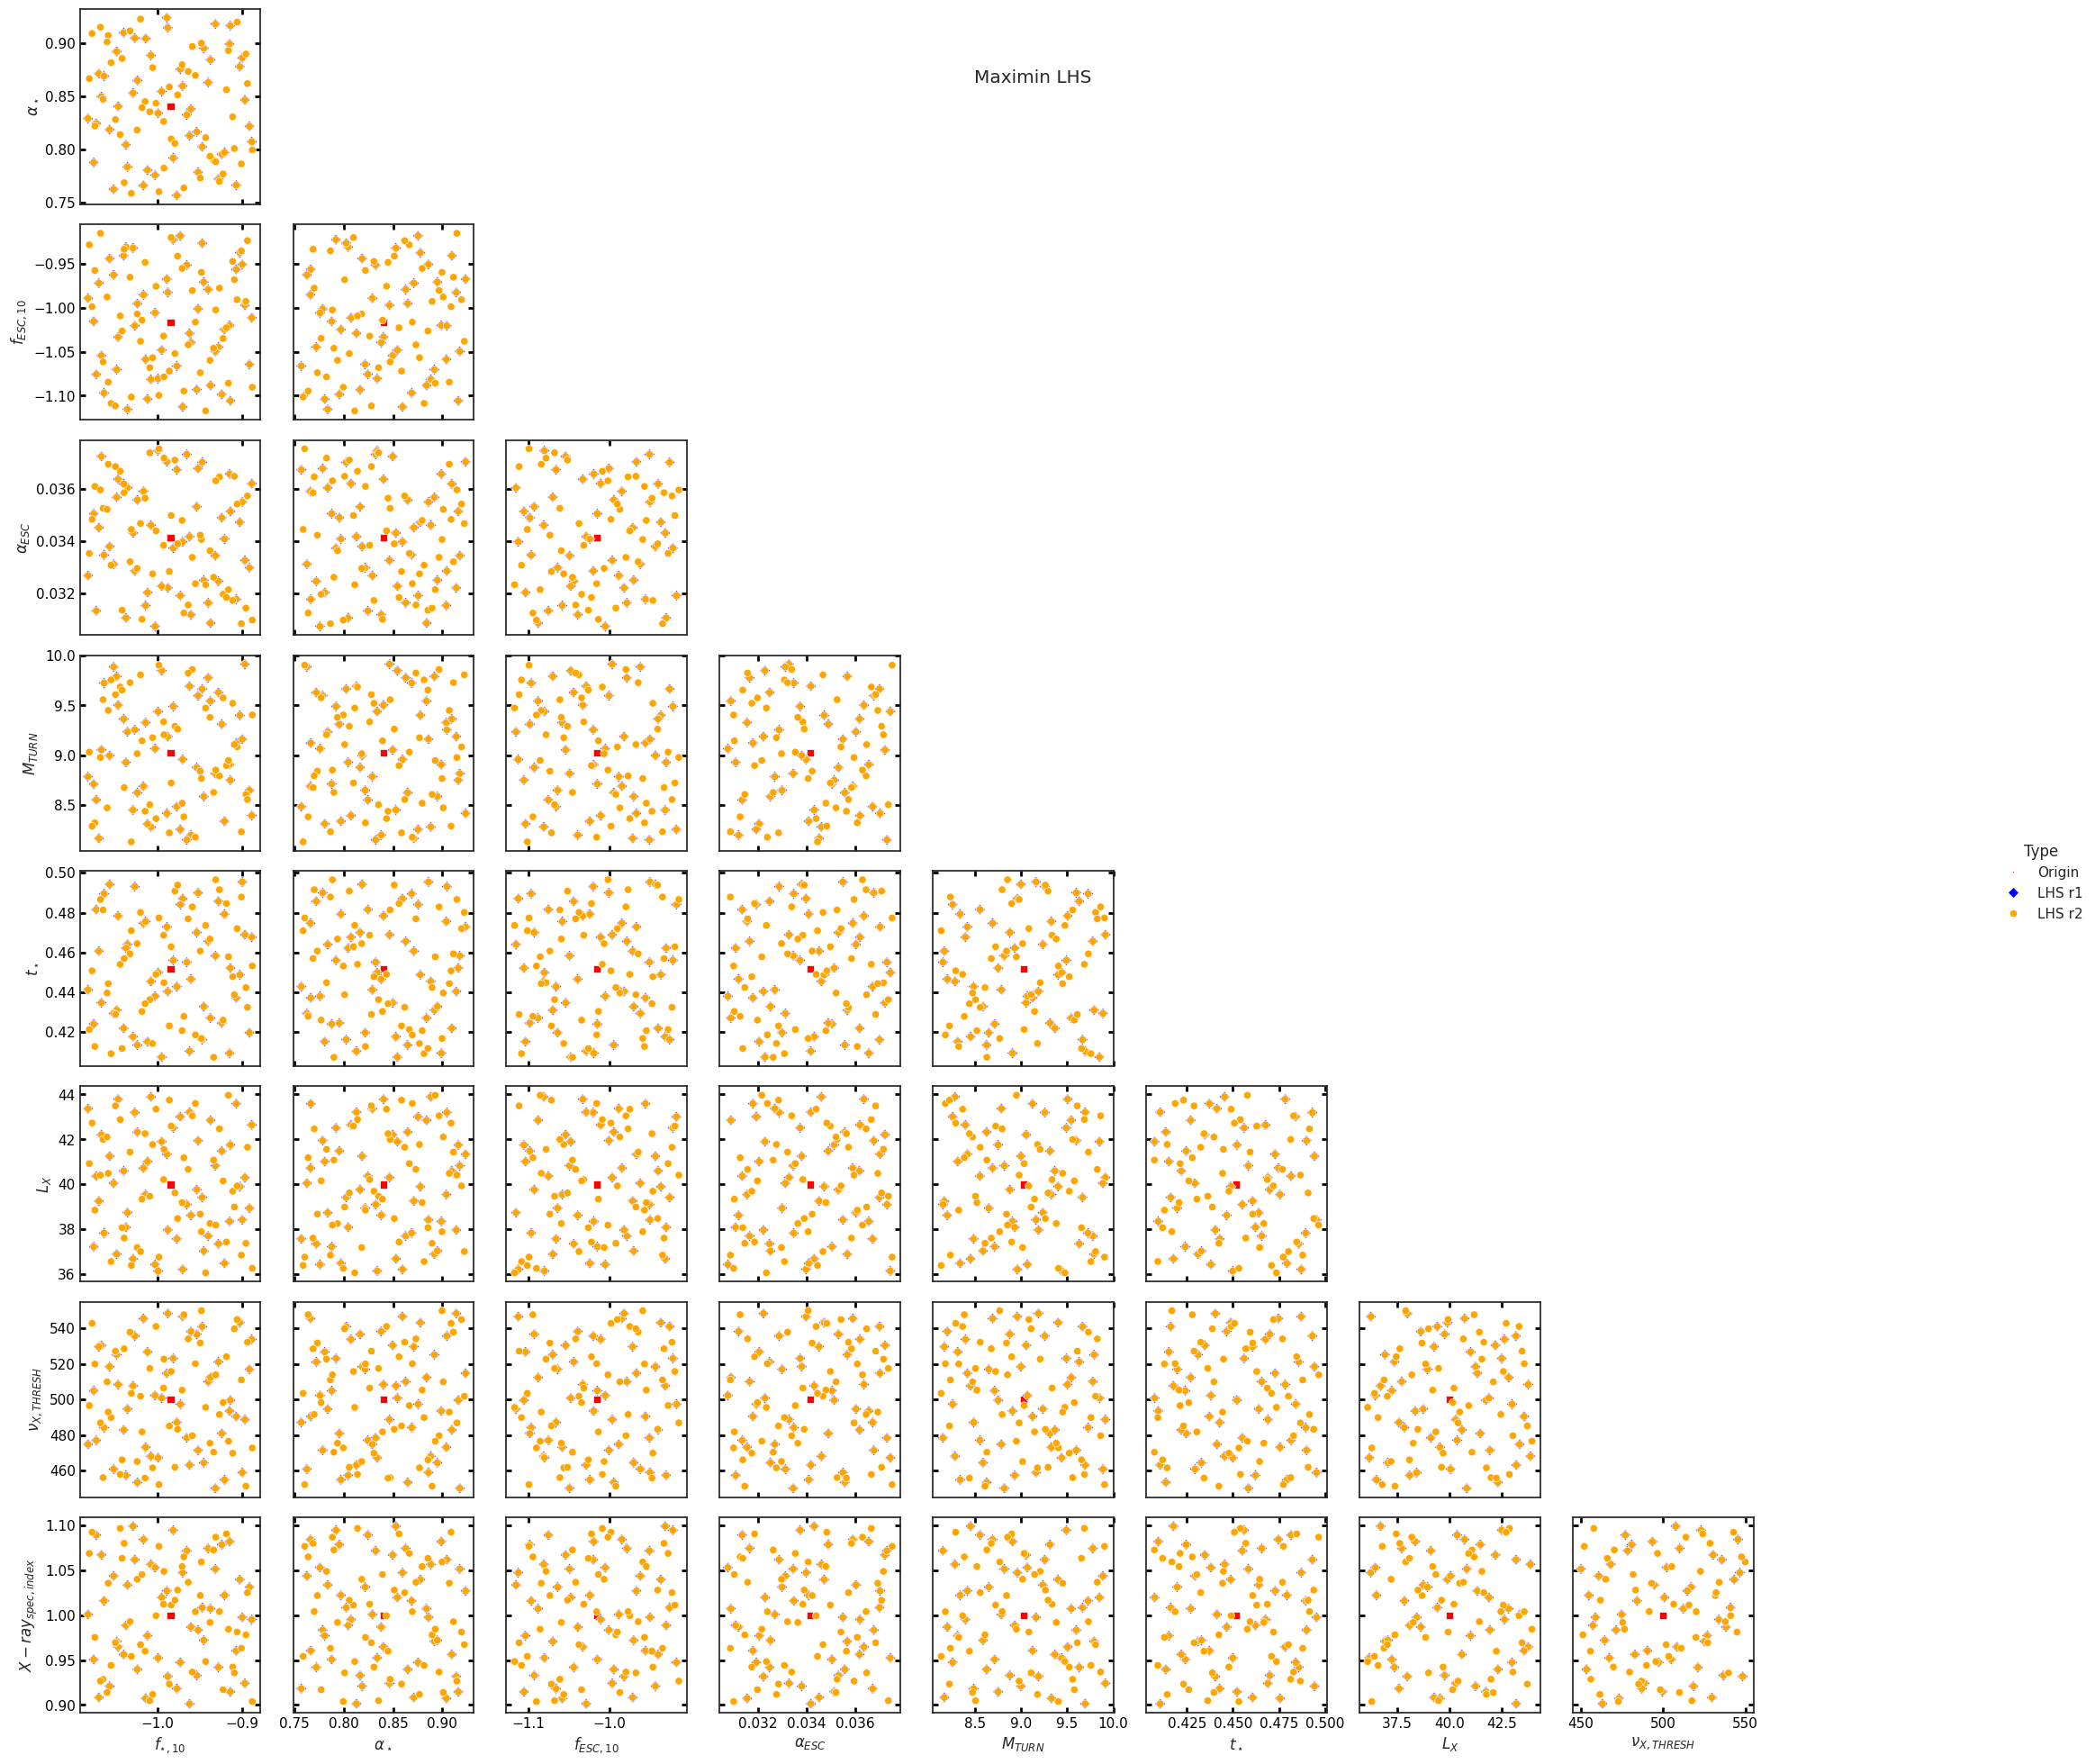

In [ ]:
def lhs_sampler(n_samples, num_rounds, lower_boundaries, upper_boundaries):

    dataframes = []

    sampler = qmc.LatinHypercube(d = len(test_param), optimization = 'random-cd')
    sample = sampler.random(n = n_samples)
    scaled_sample = qmc.scale(sample, lower_boundaries, upper_boundaries)


    df1 = pd.DataFrame(scaled_sample, columns = columns_names)
    df1['Type'] = 'LHS r1'
    dataframes.append(df1)

    print('Unprogressed sample discrepancy:', qmc.discrepancy(sample))

    sample_iteration = sample

    for i in range(2, num_rounds + 1):

            
            eLHS = ExpandLHS(sample_iteration)
            progressive_LHS = eLHS(n_samples, optimize = 'discrepancy')

            sample_iteration = np.vstack([sample_iteration, progressive_LHS])

            scaled_pro_LHS = qmc.scale(progressive_LHS, lower_boundaries, upper_boundaries)

            dataframes.append('df' + f'{i}')
            dataframes[i - 1] = pd.DataFrame(scaled_pro_LHS, columns = columns_names)
            dataframes[i - 1]['Type'] = f'LHS r{i}'

            print(f'Progressed sample {i} discrepancy:', qmc.discrepancy(progressive_LHS))
            print('Degree', eLHS.degree(n_samples))
        
    df_true = df.copy()
    df_true['Type'] = 'Origin'

    
    all_points = pd.concat([df_true] + dataframes, ignore_index = True)
    
    return all_points


n_samples = 50
num_rounds = 2

lhs = lhs_sampler(num_rounds = num_rounds, n_samples = n_samples, lower_boundaries = lower_boundaries, upper_boundaries = upper_boundaries)

corner_plot(lhs, 'Maximin LHS', '50x2_progressed')